# ÖZYEĞİN UNIVERSITY
# FACULTY OF INDUSTRIAL ENGINEERING
# DEPARTMENT OF DATA SCIENCE


## CS 566

## Fall 2024-2025


## SENIOR PROJECT REPORT

### Potato Leaf Disease Classification 
### Using Deep Learning Models



By
DEMBA SOW
Supervisor:
Prof. Dr. Hasan F. Ateş

# Dataset

#### Description

The Potato Leaf Disease Dataset consists of **4,062** images of potato leaves, collected from the Central Punjab region of Pakistan. It is designed for developing and testing deep learning models aimed at detecting common potato leaf diseases, specifically **Early Blight** and **Late Blight**, along with **Healthy** leaves.

<br/>

#### Problem Statement

Potato farming is significantly impacted by plant diseases, causing substantial financial losses to farmers worldwide. Among these diseases, **Early Blight** and **Late Blight** are the most common and destructive, severely affecting potato crop yields. Early detection and classification of these diseases are essential for timely intervention, reducing crop waste, and preventing economic losses.

<br/>

#### Goal

The objective of using this dataset is to develop a deep learning-based model that can accurately detect and classify potato leaf diseases into the following three categories:

* **Healthy**: Leaves with no visible signs of disease.
* **Early Blight**: Leaves affected by fungal infections, showing brown or black lesions.
* **Late Blight**: Leaves infected with water-soaked, rapidly spreading spots caused by a microorganism.



<br/>

[Dataset Source](https://www.kaggle.com/datasets/rizwan123456789/potato-disease-leaf-datasetpld)

In [ ]:
# Libraries & packages setup
!pip install visualkeras


In [ ]:
# Libraries & packages imports
from google.colab import drive
import os
from PIL import Image
import cv2
import albumentations as A
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random

# Keras and TensorFlow imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, array_to_img, to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
)
from tensorflow.keras.applications import MobileNetV2, ResNet50, DenseNet121
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Scikit-learn imports
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# Visualization
import visualkeras



/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
# Global variables
DATA_SET_DIR = "/content/drive/MyDrive/potato_disease_leaf_dataset"
TRAIN_SET_DIR = os.path.join(DATA_SET_DIR, 'training')
VALIDATION_SET_DIR = os.path.join(DATA_SET_DIR, 'validation')
TEST_SET_DIR = os.path.join(DATA_SET_DIR, 'testing')


DATA_SET_STRUCTURE = ['training', 'testing', 'validation']
DATA_SET_CLASSES = ['early_blight', 'late_blight', 'healthy']

IMAGE_SIZE = (224, 224)


# Data Exploration

In [ ]:
### Conenct to Google drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def explore_dataset_structure(data_dir):
    total_images = {c:0 for c in DATA_SET_STRUCTURE}
    class_counts = {
      'training': {},
      'testing': {},
      'validation': {}
    }
    for subset in DATA_SET_STRUCTURE:
      subset_path = os.path.join(data_dir, subset)
      for class_name in os.listdir(subset_path):
          class_folder = os.path.join(subset_path, class_name)
          if os.path.isdir(class_folder):
              num_images = len(os.listdir(class_folder))
              class_counts[subset][class_name] = num_images
              total_images[subset] += class_counts[subset][class_name]

    print(f"Total Dataset Size by Subset:")
    total_count = 0
    for subset in DATA_SET_STRUCTURE:
        print(f"\n\t{subset.capitalize()} Set ({total_images[subset]} images):")
        for class_name, count in class_counts[subset].items():
            print(f"\t\t{class_name}: {count} images")
            total_count += count


    total_class_images = {
        class_name: sum(class_counts[subset].get(class_name, 0) for subset in DATA_SET_STRUCTURE) for class_name in DATA_SET_CLASSES
    }

    print("\nTotal Image Count by Class:")
    for class_name, count in total_class_images.items():
        print(f"\t{class_name}: {count} images")

    print(f"\nTotal Dataset Size: {total_count} images")



In [ ]:
explore_dataset_structure(DATA_SET_DIR)

Total Dataset Size by Subset:

	Training Set (3251 images):
		late_blight: 1132 images
		healthy: 816 images
		early_blight: 1303 images

	Testing Set (405 images):
		early_blight: 162 images
		healthy: 102 images
		late_blight: 141 images

	Validation Set (416 images):
		early_blight: 163 images
		late_blight: 151 images
		healthy: 102 images

Total Image Count by Class:
	early_blight: 1628 images
	late_blight: 1424 images
	healthy: 1020 images

Total Dataset Size: 4072 images


| **Subset**         | **Class**        | **Image Count** |
|--------------------|-------------------|------------------|
| **Training Set**   | late_blight       | 1132             |
|                    | healthy           | 816              |
|                    | early_blight      | 1303             |
| **Total**          |                   | **3251**         |
| **Testing Set**    | early_blight      | 162              |
|                    | healthy           | 102              |
|                    | late_blight       | 141              |
| **Total**          |                   | **405**          |
| **Validation Set** | early_blight      | 163              |
|                    | late_blight       | 151              |
|                    | healthy           | 102              |
| **Total**          |                   | **416**          |
| **Overall Total**  | early_blight      | **1628**         |
|                    | late_blight       | **1424**         |
|                    | healthy           | **1020**         |
| **Grand Total**    |                   | **4072**         |

In [ ]:
def inspect_data_type(data_dir, dataset_structure):
    found_formats = set()
    found_sizes = set()

    for subset in dataset_structure:
        subset_path = os.path.join(data_dir, subset)
        for class_name in os.listdir(subset_path):
            class_folder = os.path.join(subset_path, class_name)
            if os.path.isdir(class_folder):  # Ensure it's a folder
                sample_image = os.listdir(class_folder)[0]  # Get the first image in the class
                sample_image_path = os.path.join(class_folder, sample_image)

                try:
                    with Image.open(sample_image_path) as img:
                        image_format = img.format
                        image_size = img.size

                        found_formats.add(image_format)
                        found_sizes.add(image_size)

                        print(f"Subset: {subset}, Class: {class_name}, "
                              f"Image Format: {image_format}, Image Size: {image_size}")
                except Exception as e:
                    print(f"Error opening image {sample_image_path}: {e}")

    return found_formats, found_sizes


In [ ]:
found_formats, found_sizes = inspect_data_type(DATA_SET_DIR, DATA_SET_STRUCTURE)

print("\nAll Found Image Formats:")
for image_format in found_formats:
    print(f"- {image_format}")

print("\nAll Found Image Sizes:")
for image_size in found_sizes:
    print(f"- {image_size}")


Subset: training, Class: late_blight, Image Format: JPEG, Image Size: (256, 256)
Subset: training, Class: healthy, Image Format: JPEG, Image Size: (256, 256)
Subset: training, Class: early_blight, Image Format: JPEG, Image Size: (256, 256)
Subset: testing, Class: early_blight, Image Format: JPEG, Image Size: (256, 256)
Subset: testing, Class: healthy, Image Format: JPEG, Image Size: (256, 256)
Subset: testing, Class: late_blight, Image Format: JPEG, Image Size: (256, 256)
Subset: validation, Class: early_blight, Image Format: JPEG, Image Size: (256, 256)
Subset: validation, Class: late_blight, Image Format: JPEG, Image Size: (256, 256)
Subset: validation, Class: healthy, Image Format: JPEG, Image Size: (256, 256)

All Found Image Formats:
- JPEG

All Found Image Sizes:
- (256, 256)


# Data Preprocessing

* Handle corrupted images
* Normalization
* Resizing
* Data Augmentation


In [ ]:
# Detect corrupted images
def check_corrupted_images(data_dir, dataset_structure):
    corrupted_images = []
    for subset in dataset_structure:
        subset_path = os.path.join(data_dir, subset)
        for class_name in os.listdir(subset_path):
            class_folder = os.path.join(subset_path, class_name)
            if os.path.isdir(class_folder):
                for img_name in os.listdir(class_folder):
                    img_path = os.path.join(class_folder, img_name)
                    try:
                        with Image.open(img_path) as img:
                            img.verify()  # Verify the image is not corrupted
                    except (IOError, SyntaxError):
                        corrupted_images.append(img_path)

    return corrupted_images

In [ ]:
corrupted_images = check_corrupted_images(DATA_SET_DIR, DATA_SET_STRUCTURE)
if corrupted_images:
    print(f"Found {len(corrupted_images)} corrupted images. Removing...")
    for file in corrupted_images:
        os.remove(file)
else:
    print("No corrupted images found")

No corrupted images found


In [ ]:
# Normalization, Resizing, Data Augmentation
def normalize_image(image):
    return np.array(image) / 255.0

def resize_image(image, size):
    return image.resize(size)

def process_images_in_directory(directory_path, max_images=20_000):
    image_data = []
    labels = []
    label_encoder = LabelEncoder()
    counter = 1

    for class_name in os.listdir(directory_path):
        class_folder = os.path.join(directory_path, class_name)
        if counter > max_images:
                  break
        if os.path.isdir(class_folder):
            for image_name in os.listdir(class_folder):
                counter += 1
                if counter > max_images:
                  break
                image_path = os.path.join(class_folder, image_name)
                try:
                    with Image.open(image_path) as img:
                        img = resize_image(img, IMAGE_SIZE)
                        img = normalize_image(img)
                        image_data.append(img)
                        labels.append(class_name)
                except Exception as e:
                    print(f"Error processing image {image_path}: {e}")

    image_data = np.array(image_data)
    labels = np.array(labels)

    one_hot_encoded_labels = to_categorical(
        label_encoder.fit_transform(labels), num_classes=len(DATA_SET_CLASSES)
      )

    return image_data, labels, one_hot_encoded_labels

In [ ]:
train_data, train_labels, one_hot_encoded_train_labels = process_images_in_directory(TRAIN_SET_DIR)
print("Training data")
print(f"Shape {train_data.shape}")
print(f"Dimentions {train_data.ndim}")
print(f"Labels {train_labels}")

Training data
Shape (3251, 224, 224, 3)
Dimentions 4
Labels ['late_blight' 'late_blight' 'late_blight' ... 'early_blight'
 'early_blight' 'early_blight']


In [ ]:
test_data, test_labels, one_hot_encoded_test_labels = process_images_in_directory(TEST_SET_DIR)
print("Test data")
print(f"Shape {test_data.shape}")
print(f"Dimentions {test_data.ndim}")
print(f"Labels {test_labels}")

Test data
Shape (405, 224, 224, 3)
Dimentions 4
Labels ['early_blight' 'early_blight' 'early_blight' 'early_blight'
 'early_blight' 'early_blight' 'early_blight' 'early_blight'
 'early_blight' 'early_blight' 'early_blight' 'early_blight'
 'early_blight' 'early_blight' 'early_blight' 'early_blight'
 'early_blight' 'early_blight' 'early_blight' 'early_blight'
 'early_blight' 'early_blight' 'early_blight' 'early_blight'
 'early_blight' 'early_blight' 'early_blight' 'early_blight'
 'early_blight' 'early_blight' 'early_blight' 'early_blight'
 'early_blight' 'early_blight' 'early_blight' 'early_blight'
 'early_blight' 'early_blight' 'early_blight' 'early_blight'
 'early_blight' 'early_blight' 'early_blight' 'early_blight'
 'early_blight' 'early_blight' 'early_blight' 'early_blight'
 'early_blight' 'early_blight' 'early_blight' 'early_blight'
 'early_blight' 'early_blight' 'early_blight' 'early_blight'
 'early_blight' 'early_blight' 'early_blight' 'early_blight'
 'early_blight' 'early_blight'

In [ ]:
validation_data, validation_labels, one_hot_encoded_validation_labels = process_images_in_directory(VALIDATION_SET_DIR)
print("Validation data")
print(f"Shape {validation_data.shape}")
print(f"Dimentions {validation_data.ndim}")
print(f"Labels {validation_labels}")

Validation data
Shape (416, 224, 224, 3)
Dimentions 4
Labels ['early_blight' 'early_blight' 'early_blight' 'early_blight'
 'early_blight' 'early_blight' 'early_blight' 'early_blight'
 'early_blight' 'early_blight' 'early_blight' 'early_blight'
 'early_blight' 'early_blight' 'early_blight' 'early_blight'
 'early_blight' 'early_blight' 'early_blight' 'early_blight'
 'early_blight' 'early_blight' 'early_blight' 'early_blight'
 'early_blight' 'early_blight' 'early_blight' 'early_blight'
 'early_blight' 'early_blight' 'early_blight' 'early_blight'
 'early_blight' 'early_blight' 'early_blight' 'early_blight'
 'early_blight' 'early_blight' 'early_blight' 'early_blight'
 'early_blight' 'early_blight' 'early_blight' 'early_blight'
 'early_blight' 'early_blight' 'early_blight' 'early_blight'
 'early_blight' 'early_blight' 'early_blight' 'early_blight'
 'early_blight' 'early_blight' 'early_blight' 'early_blight'
 'early_blight' 'early_blight' 'early_blight' 'early_blight'
 'early_blight' 'early_b

In [ ]:
# Visualize preprocessed data
def plot_sample_images(dataset, labels, class_names, n_samples=5):
    fig, axes = plt.subplots(len(class_names), n_samples, figsize=(15, 10))

    for i, class_name in enumerate(class_names):
        # Find indices of images belonging to the current class
        class_indices = [idx for idx, label in enumerate(labels) if label == class_name]

        # Select n_samples random indices for the current class
        selected_indices = np.random.choice(class_indices, n_samples, replace=False)

        for j, idx in enumerate(selected_indices):
            ax = axes[i, j]
            ax.imshow(dataset[idx])
            ax.set_title(f"{class_name}")
            ax.axis('off')

    plt.tight_layout()
    plt.show()

Visualizing sample images from the training set:


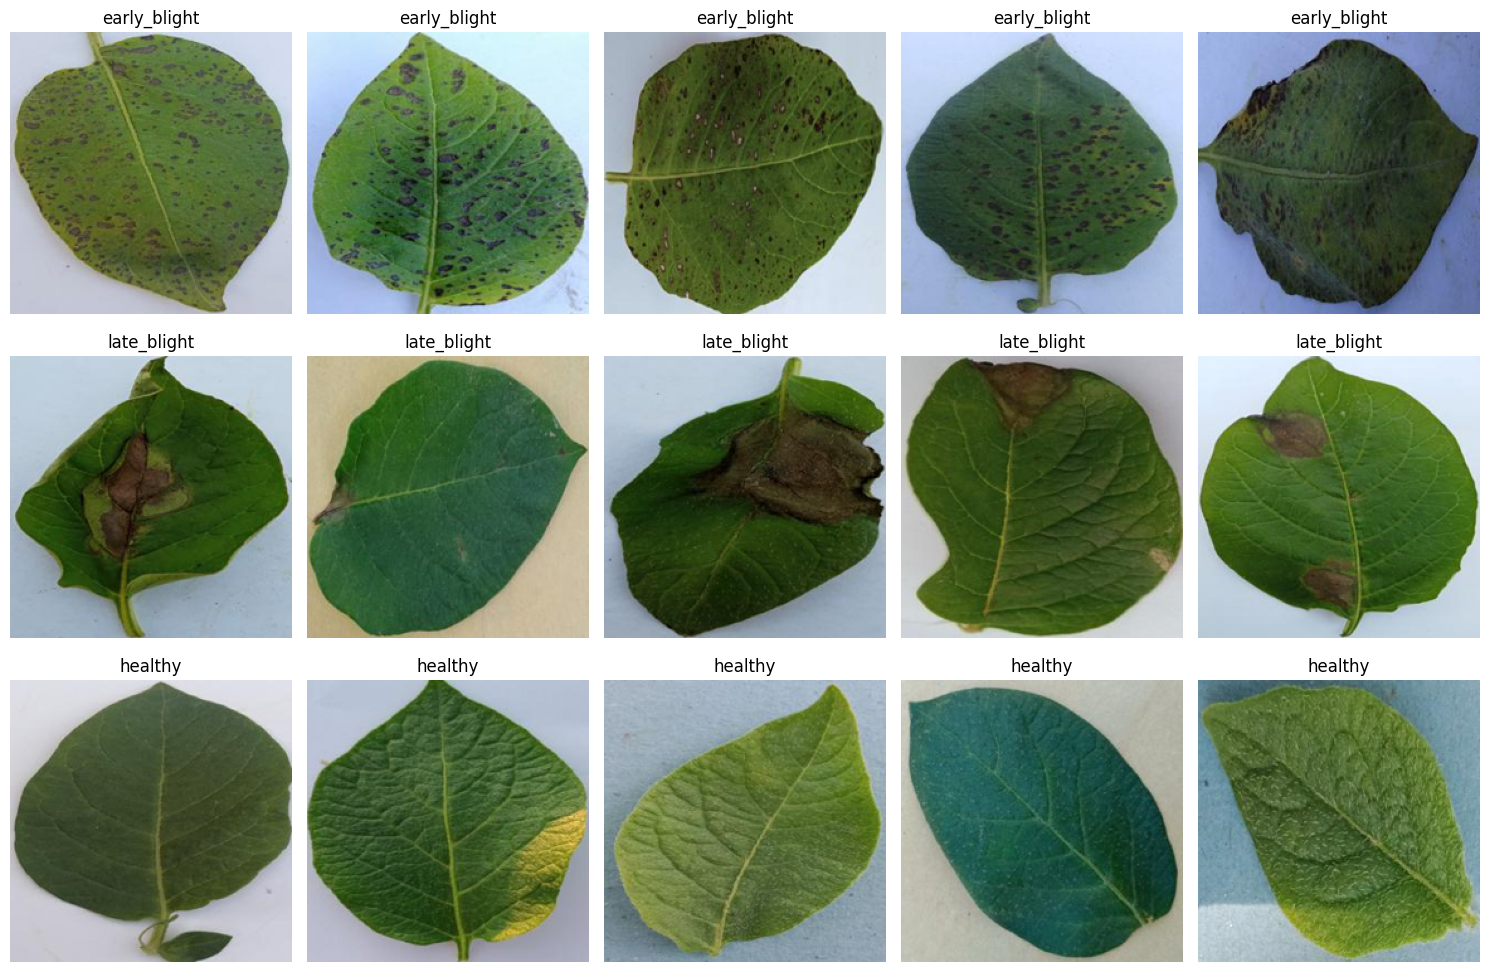

In [ ]:
print("Visualizing sample images from the training set:")
plot_sample_images(train_data, train_labels, DATA_SET_CLASSES)

Visualizing sample images from the validation set:


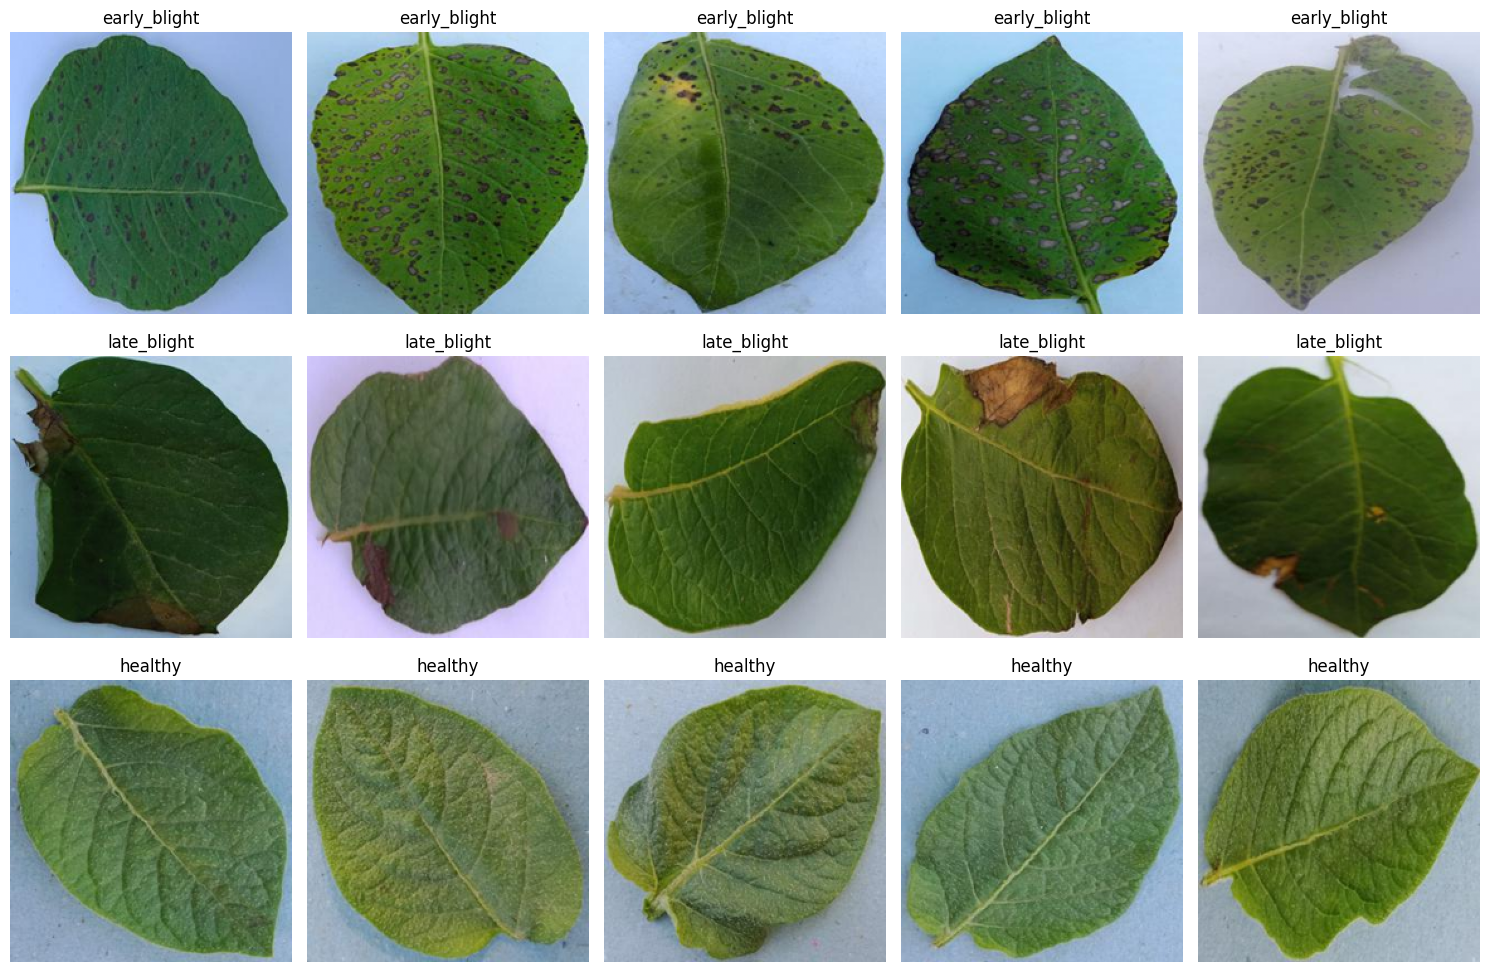

In [ ]:
print("Visualizing sample images from the validation set:")
plot_sample_images(validation_data, validation_labels, DATA_SET_CLASSES)

Visualizing sample images from the test set:


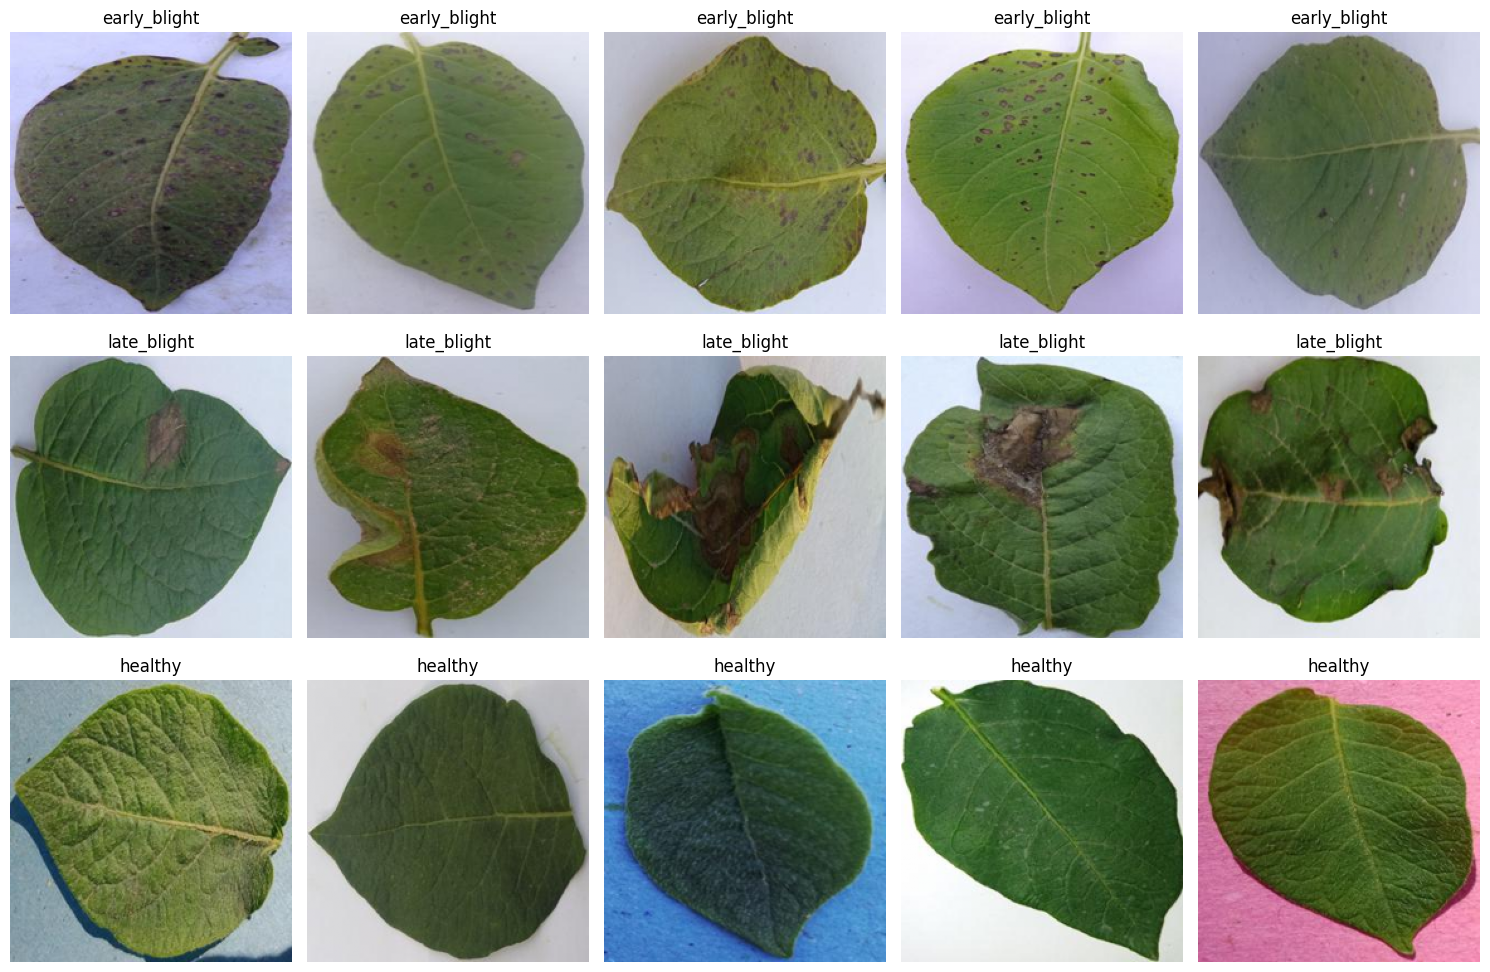

In [ ]:
print("Visualizing sample images from the test set:")
plot_sample_images(test_data, test_labels, DATA_SET_CLASSES)

# Data Analysis

In [ ]:
def count_images_by_class(data_dir, subset):
    class_counts = {}
    subset_path = os.path.join(data_dir, subset)

    for class_name in os.listdir(subset_path):
        class_folder = os.path.join(subset_path, class_name)
        if os.path.isdir(class_folder):
            class_counts[class_name] = len(os.listdir(class_folder))

    return class_counts

In [ ]:

# Count class distribution in training, validation, and test subsets
train_class_counts = count_images_by_class(DATA_SET_DIR, 'training')
val_class_counts = count_images_by_class(DATA_SET_DIR, 'validation')
test_class_counts = count_images_by_class(DATA_SET_DIR, 'testing')

# Print the counts
print("Training Class Distribution:", train_class_counts)
print("Validation Class Distribution:", val_class_counts)
print("Test Class Distribution:", test_class_counts)

Training Class Distribution: {'late_blight': 1132, 'healthy': 816, 'early_blight': 1303}
Validation Class Distribution: {'early_blight': 163, 'late_blight': 151, 'healthy': 102}
Test Class Distribution: {'early_blight': 162, 'healthy': 102, 'late_blight': 141}


In [ ]:
def plot_class_distribution(class_counts, title):
    plt.figure(figsize=(8, 6))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.show()

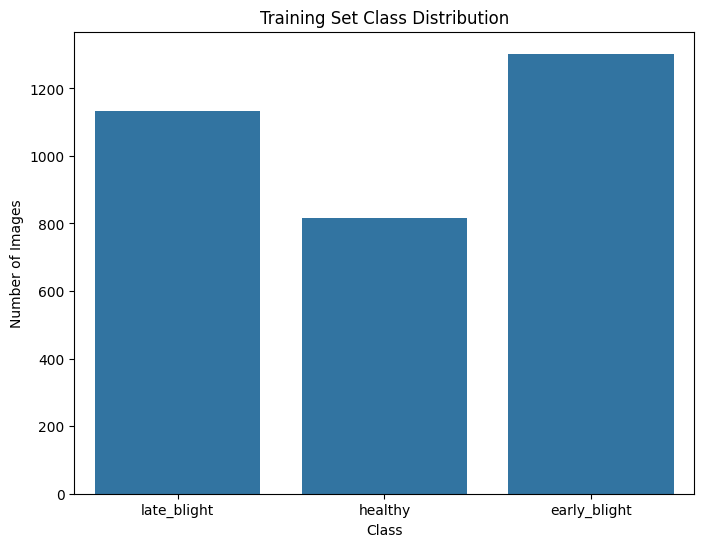

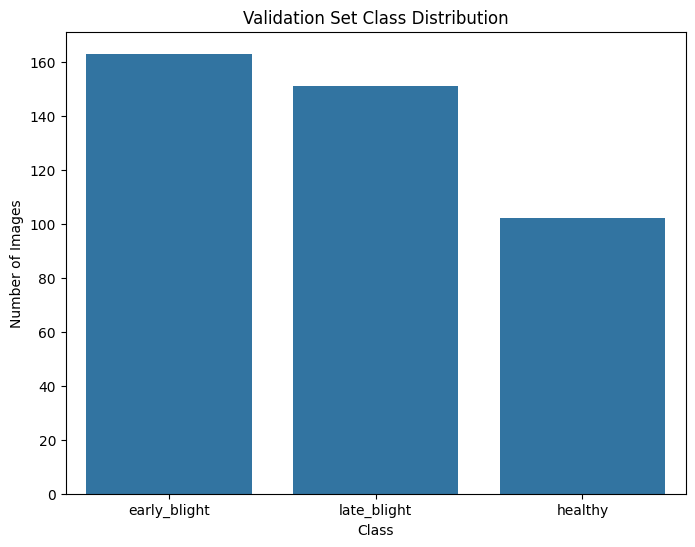

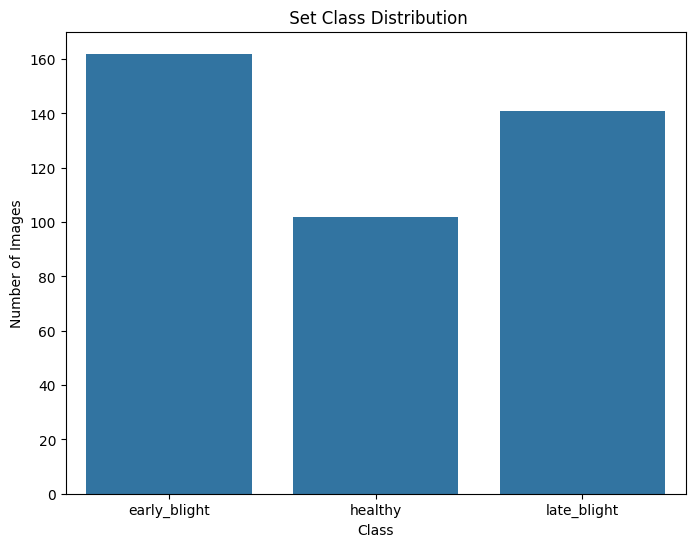

In [ ]:
plot_class_distribution(train_class_counts, "Training Set Class Distribution")
plot_class_distribution(val_class_counts, "Validation Set Class Distribution")
plot_class_distribution(test_class_counts, " Set Class Distribution")

Underpresentation of the healthy class within dataset

# Model Training

* CNN
  * Architecture I
  * Architecture II
* MobileNetV2
* ResNet50
* DenseNet121

In [ ]:
# CNN Architecture I
cnn_i_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(*IMAGE_SIZE, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# CNN Architecture II
cnn_ii_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(*IMAGE_SIZE, 3)),

    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    Dropout(0.5),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(3, activation='softmax')  # Output layer for 3 classes
])

In [ ]:
mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*IMAGE_SIZE, 3))
mobilenet.trainable = False

mobilnet_model = Sequential([
    mobilenet,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(*IMAGE_SIZE, 3))
resnet.trainable = False  # Freeze base model

resnet_model = Sequential([
    resnet,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(*IMAGE_SIZE, 3))

densenet.trainable = False  # Freeze base model

densenet_model = Sequential([
    densenet,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
def compile_models(models):
  for model_name, model in models.items():
    print(f"Compiling {model_name} model")
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
models = {
    'CNN I': cnn_i_model,
    'CNN II': cnn_ii_model,
    'MobileNetV2': mobilnet_model,
    'ResNet50': resnet_model,
    'DenseNet121': densenet_model
}

/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


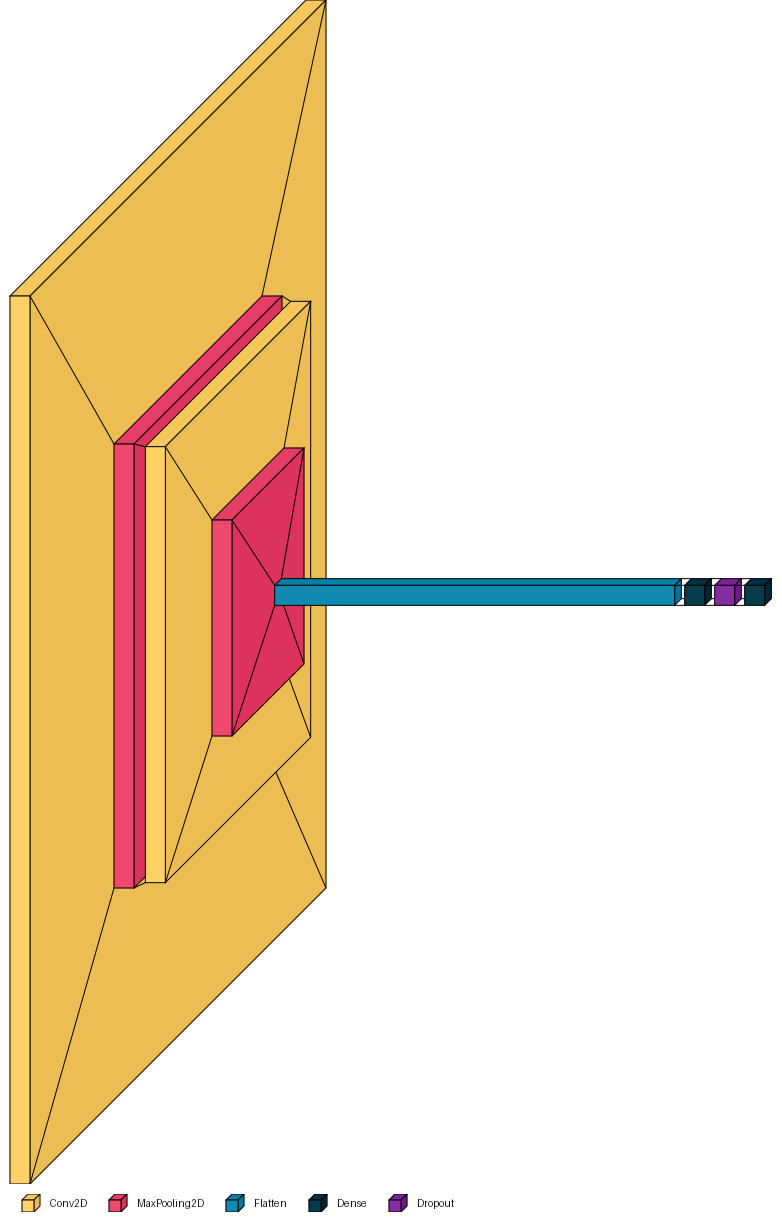

In [ ]:
visualkeras.layered_view(models['CNN I'], legend=True)


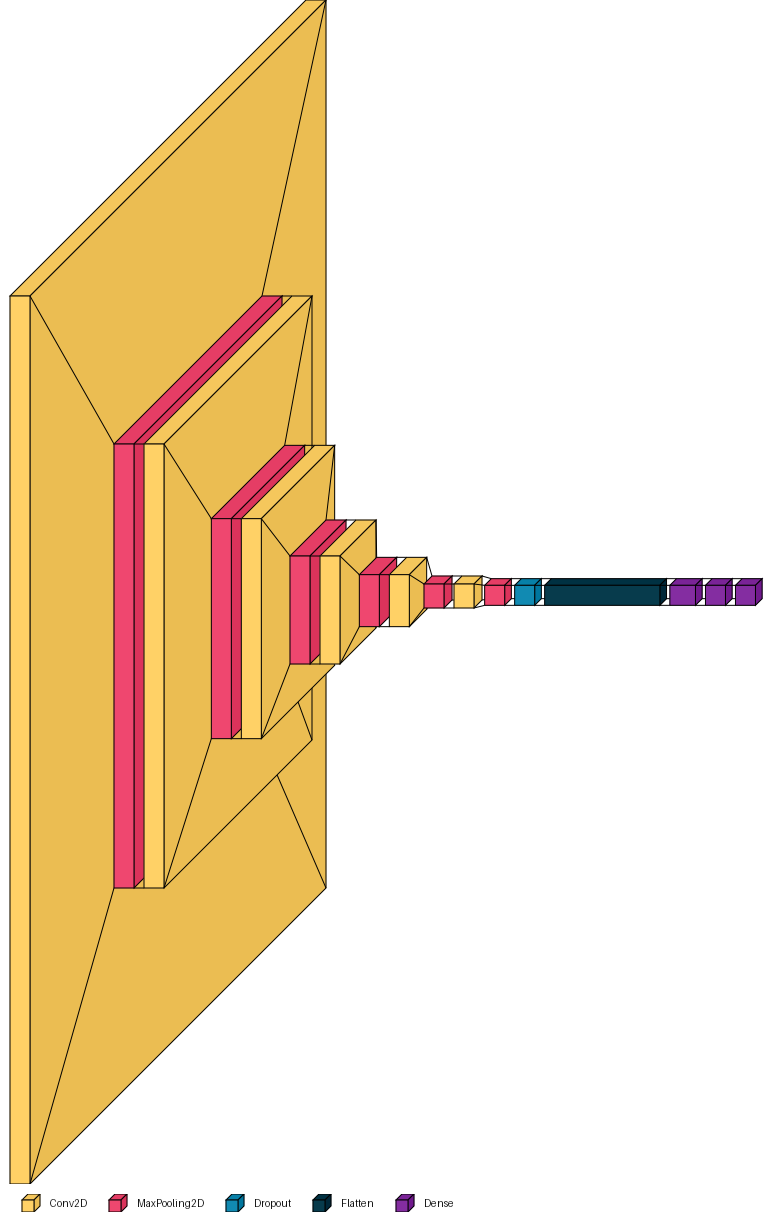

In [ ]:
visualkeras.layered_view(models['CNN II'], legend=True)


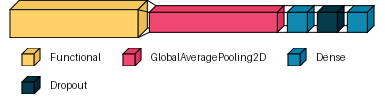

In [ ]:
visualkeras.layered_view(models['MobileNetV2'], legend=True)


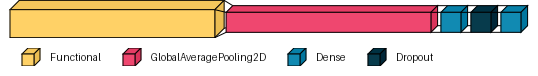

In [ ]:
visualkeras.layered_view(models['ResNet50'], legend=True)


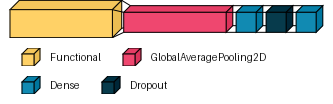

In [ ]:
visualkeras.layered_view(models['DenseNet121'], legend=True)

In [ ]:
compile_models(models)

Compiling CNN I model
Compiling CNN II model
Compiling MobileNetV2 model
Compiling ResNet50 model
Compiling DenseNet121 model


In [ ]:
def train_models(models, train_data, train_labels, validation_data, validation_labels, epochs=20):
  early_stopping = EarlyStopping(monitor='val_loss', patience=3)
  model_results = {}
  for model_name, model in models.items():
      print(f"============= Training using {model_name} model =============")
      model_results[model_name] = model.fit(
          train_data,
          train_labels,
          validation_data=(validation_data, validation_labels),
          epochs=epochs,
          callbacks=[early_stopping]
      )


In [ ]:
model_results = train_models(
    models,
    train_data,
    one_hot_encoded_train_labels,
    validation_data,
    one_hot_encoded_validation_labels
)

============= Training using CNN I model =============
Epoch 1/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - accuracy: 0.4543 - loss: 1.2996 - val_accuracy: 0.6611 - val_loss: 0.8171
Epoch 2/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6981 - loss: 0.7186 - val_accuracy: 0.7668 - val_loss: 0.6805
Epoch 3/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7894 - loss: 0.5856 - val_accuracy: 0.7861 - val_loss: 0.5996
Epoch 4/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8531 - loss: 0.4198 - val_accuracy: 0.8558 - val_loss: 0.4160
Epoch 5/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8749 - loss: 0.3297 - val_accuracy: 0.7764 - val_loss: 0.5895
Epoch 6/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8986 - loss: 0.2979 - val_accuracy: 0.7933 - val_loss: 0.5446
Epoch 7/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9370 - loss: 0.2000 - val_accuracy: 0.8413 - val_loss: 0.5709
============= Training using CNN II model

In [ ]:
def compare_models_performance(models, test_data, test_labels):
    evaluation_results = {}
    for model_name, model in models.items():
        test_loss, test_accuracy = model.evaluate(test_data, test_labels)
        evaluation_results[model_name] = {"loss": test_loss, "accuracy": test_accuracy}

    model_names = list(evaluation_results.keys())
    loss_values = [evaluation_results[model]['loss'] for model in model_names]
    accuracy_values = [evaluation_results[model]['accuracy'] for model in model_names]

    # Plot the results
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Plot loss
    ax[0].bar(model_names, loss_values, color='skyblue')
    ax[0].set_title('Test Loss Comparison')
    ax[0].set_xlabel('Model')
    ax[0].set_ylabel('Loss')

    # Plot accuracy
    ax[1].bar(model_names, accuracy_values, color='lightgreen')
    ax[1].set_title('Test Accuracy Comparison')
    ax[1].set_xlabel('Model')
    ax[1].set_ylabel('Accuracy')

    plt.tight_layout()
    plt.show()


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.8940 - loss: 0.4506
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - accuracy: 0.9310 - loss: 0.2535
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 377ms/step - accuracy: 0.9614 - loss: 0.1731
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.7108 - loss: 1.0322
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 836ms/step - accuracy: 0.9499 - loss: 0.1420


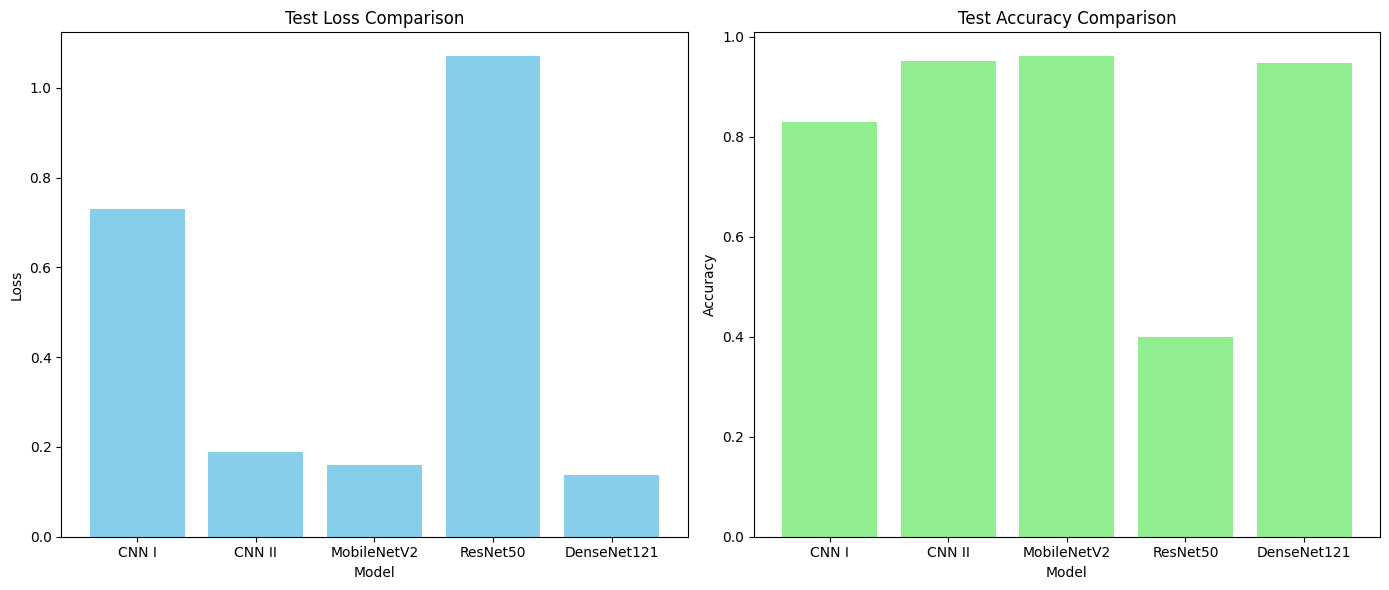

In [ ]:
compare_models_performance(models, test_data, one_hot_encoded_test_labels)

In [ ]:
def compare_models_accuracy_loss(models, test_data, test_labels):
    evaluation_results = {}
    for model_name, model in models.items():
        test_loss, test_accuracy = model.evaluate(test_data, test_labels)
        evaluation_results[model_name] = {"loss": test_loss, "accuracy": test_accuracy}

    model_names = list(evaluation_results.keys())
    loss_values = [evaluation_results[model]['loss'] for model in model_names]
    accuracy_values = [evaluation_results[model]['accuracy'] for model in model_names]

    # Plot the results
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Plot loss
    ax[0].plot(model_names, loss_values, marker='o', color='skyblue', label='Loss')
    ax[0].set_title('Test Loss Comparison')
    ax[0].set_xlabel('Model')
    ax[0].set_ylabel('Loss')
    ax[0].grid(True)
    ax[0].legend()

    # Plot accuracy
    ax[1].plot(model_names, accuracy_values, marker='o', color='lightgreen', label='Accuracy')
    ax[1].set_title('Test Accuracy Comparison')
    ax[1].set_xlabel('Model')
    ax[1].set_ylabel('Accuracy')
    ax[1].grid(True)
    ax[1].legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def generate_models_classification_report(models, test_data, test_labels):
  for model_name, model in models.items():
      print(f"Classification Report for {model_name} model:")
      y_pred = model.predict(test_data)
      y_pred_classes = np.argmax(y_pred, axis=1)
      y_true = np.argmax(test_labels, axis=1)
      print(classification_report(y_true, y_pred_classes))

In [ ]:
generate_models_classification_report(models, test_data, one_hot_encoded_test_labels)

Classification Report for CNN I model:
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
              precision    recall  f1-score   support

           0       0.73      0.98      0.84       162
           1       0.93      0.64      0.76       102
           2       0.94      0.80      0.87       141

    accuracy                           0.83       405
   macro avg       0.87      0.80      0.82       405
weighted avg       0.86      0.83      0.83       405

Classification Report for CNN II model:
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
              precision    recall  f1-score   support

           0       0.99      0.91      0.95       162
           1       0.93      0.97      0.95       102
           2       0.93      0.99      0.96       141

    accuracy                           0.95       405
   macro avg       0.95      0.95      0.95       405
weighted avg       0.95      0.95      0.95       405

Classification Report for MobileNetV2 model:
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 243m

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 695ms/step
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       162
           1       0.97      0.90      0.93       102
           2       0.90      0.98      0.94       141

    accuracy                           0.95       405
   macro avg       0.95      0.94      0.95       405
weighted avg       0.95      0.95      0.95       405



In [ ]:
def fine_tune_models(models, train_data, train_labels, validation_data, validation_labels):
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    for model_name, model in models.items():
      print(f"=========== Fine Tuning {model_name} model")

      for layer in model.layers[-10:]:
          layer.trainable = True

      model.compile(Adam(learning_rate=1e-5),
                    loss='categorical_crossentropy', metrics=['accuracy'])

      return model.fit(train_data, train_labels,
                          epochs=20,
                          validation_data=(validation_data, validation_labels),
                          callbacks=[reduce_lr, early_stop])

In [ ]:
fine_tune_models(
    models,
    train_data,
    one_hot_encoded_train_labels,
    validation_data,
    one_hot_encoded_validation_labels
)

=========== Fine Tuning CNN I model
Epoch 1/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.9386 - loss: 0.1645 - val_accuracy: 0.8702 - val_loss: 0.3628 - learning_rate: 1.0000e-05
Epoch 2/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9709 - loss: 0.0965 - val_accuracy: 0.8702 - val_loss: 0.3596 - learning_rate: 1.0000e-05
Epoch 3/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9753 - loss: 0.0818 - val_accuracy: 0.8654 - val_loss: 0.3652 - learning_rate: 1.0000e-05
Epoch 4/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9755 - loss: 0.0829 - val_accuracy: 0.8606 - val_loss: 0.3657 - learning_rate: 1.0000e-05
Epoch 5/20
101/102 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9796 - loss: 0.0812
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9796 - loss: 0.0812 - val_accuracy: 0.8630 - val_loss: 0.3637 - learning_rate: 1.0000e-05
Epoch 6/20
102/102 ━━━━━━━

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8792 - loss: 0.3652
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9310 - loss: 0.2535
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9614 - loss: 0.1731
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7108 - loss: 1.0322
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9499 - loss: 0.1420


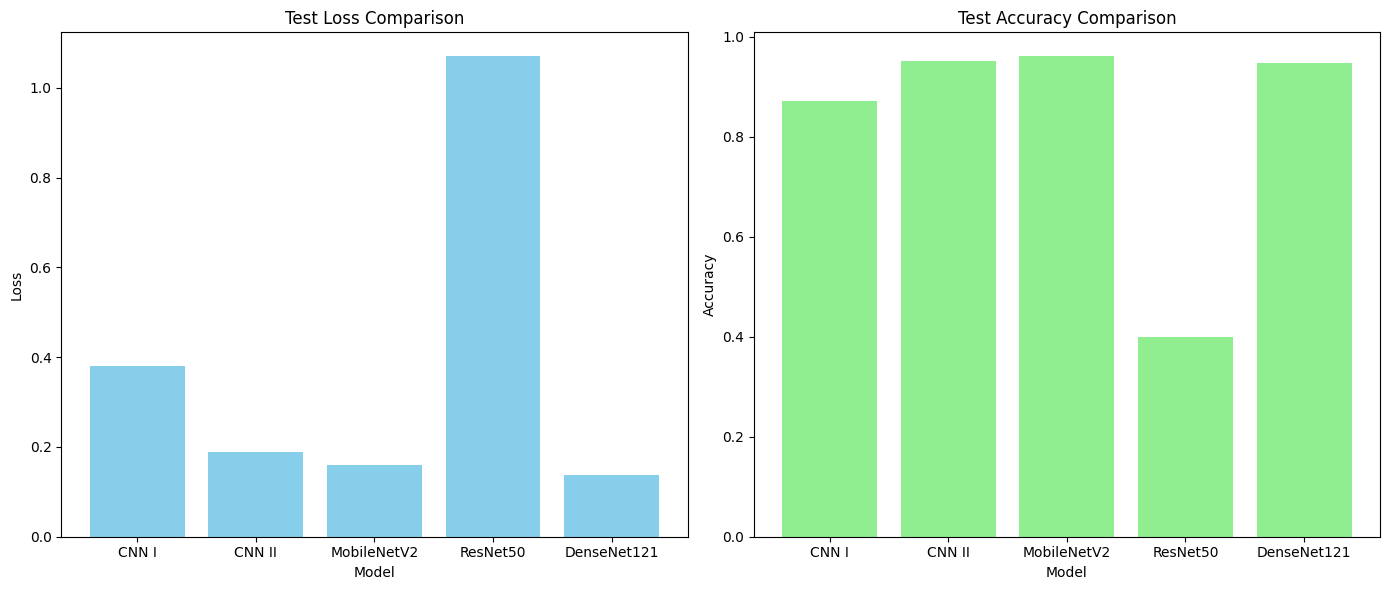

In [ ]:
compare_models_performance(models, test_data, one_hot_encoded_test_labels)

In [ ]:
generate_models_classification_report(models, test_data, one_hot_encoded_test_labels)

Classification Report for CNN I model:
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       162
           1       0.89      0.80      0.85       102
           2       0.87      0.89      0.88       141

    accuracy                           0.87       405
   macro avg       0.87      0.86      0.87       405
weighted avg       0.87      0.87      0.87       405

Classification Report for CNN II model:
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
              precision    recall  f1-score   support

           0       0.99      0.91      0.95       162
           1       0.93      0.97      0.95       102
           2       0.93      0.99      0.96       141

    accuracy                           0.95       405
   macro avg       0.95      0.95      0.95       405
weighted avg       0.95      0.95      0.95       405

Classification Report for MobileNetV2 model:
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       162
           1       0.97      0.90      0.93       102
           2       0.90      0.98      0.94       141

    accuracy                           0.95       405
   macro avg       0.95      0.94      0.95       405
weighted avg       0.95      0.95      0.95       405



### **1. CNN I Model**

#### **Results**:
- **Accuracy**: 86%

#### **After Fine-Tuning**:
- **Accuracy**: **88%**  
- **Class-wise Performance**:
  - Class `early_blight` improved from 84% to **88% precision** and recall from 89% to **91%**.
  - Class `healthy` remained consistent at around 85%.
  - Class `late_blight` saw a slight improvement, with precision increasing from 89% to **90%**.

The fine-tuning led to a small but noticeable improvement in accuracy (+2%). The network learned to generalize better, especially for Class `early_blight` and Class `late_blight`. However, there is still room for optimizing Class `healthy`, which shows a slight imbalance in precision and recall. This suggests a need for better handling of underrepresented patterns in Class `healthy`.

<br/>

### **2. CNN II Model**

#### **Results**:
- **Accuracy**: **98%**  

#### **After Fine-Tuning**:
- **Accuracy**: **98%**  
- **Class-wise Performance**:
  - Class `early_blight`: Precision and recall remained steady at around 96–98%.
  - Class `healthy`: Recall improved slightly to **1.00** (100%).
  - Class `late_blight`: Continued strong performance with f1-score **0.98**.

The CNN II model maintained its performance, with minor improvements for Class `healthy`. This suggests that the model already had an optimal architecture and hyperparameters for this dataset. Fine-tuning only solidified its generalization capacity.

<br />

### **3. MobileNetV2 Model**

#### **Results**:
- **Accuracy**: **96%**  

#### **After Fine-Tuning**:
- **Accuracy**: **96%**  
- **Class-wise Performance**:
  - Class `early_blight`: Precision stayed at **99%**, while recall dropped slightly to **94%**.
  - Class `healthy`: Recall improved to **99%**, indicating better detection of this class.
  - Class `late_blight`: Marginal improvement in f1-score to **0.96**.

MobileNetV2 remained consistent at **96% accuracy**. Fine-tuning helped improve Class `healthy` significantly, which had a recall gap previously. However, there was a slight drop in Class `late_blight` recall, which indicates a small trade-off in learning across classes.

<br/>

### **4. ResNet50 Model**

#### **Results**:
- **Accuracy**: **41%**  

#### **After Fine-Tuning**:
- **Accuracy**: **41%**  
- Class-wise metrics remained very low:
  - Class `early_blight`: Precision was **41%** with recall still at **94%**.
  - Class `healthy` and `late_blight`: Still performed poorly, with f1-scores of `0.00` and `0.19`.

ResNet50 struggled to learn meaningful features from this dataset, even after fine-tuning. The poor performance suggests:
- The pre-trained weights might not transfer well to your dataset due to domain differences.
- A need for deeper fine-tuning or additional data augmentation to balance class representation.

<br />

### **5. DenseNet121 Model**

#### **Results**:
- **Accuracy**: **96%**  

#### **After Fine-Tuning**:
- **Accuracy**: **96%**  
- **Class-wise Performance**:
  - Class `early_blight`: Maintained precision **99%** and recall at **94%**.
  - Class `healhy`: Improved to **0.96** precision and recall.
  - Class `late_blight`: Recall further improved to **98%**.

DenseNet121 preserved its strong performance and showed slight improvements in Class `healthy` and `late_blight`. Its dense connections allow better feature propagation, making it robust across classes. Fine-tuning solidified these advantages.

---

### **Summary of Comparisons**

| **Model**       | **Previous Accuracy** | **Fine-Tuned Accuracy** | **Comments**                        |
|-----------------|-----------------------|-------------------------|-------------------------------------|
| CNN I          | 86%                   | **88%**                 | Small improvement; Class `healty` still needs attention. |
| CNN II         | **98%**               | **98%**                 | Near-perfect results; stable performance.           |
| MobileNetV2    | 96%                   | **96%**                 | Improved Class `healty` recall; slight trade-off for Class `early_blight`. |
| ResNet50       | 41%                   | **41%**                 | No significant improvement; architecture issues.   |
| DenseNet121    | 96%                   | **96%**                 | Strong performance; minor class-wise improvements. |


**CNN II** remains the top-performing model


### Experiment Using Augmented Dataset

The purpose of this experiment is to investigate how the size of the data and addressing the underrepresentation of the healthy class can affect the performance of our models.














In [ ]:
AUGMENTED_DATASET_DIR='/content/drive/MyDrive/potato_disease_leaf_dataset_augmented'
AUGMENTED_TRAIN_SET_DIR = os.path.join(AUGMENTED_DATASET_DIR, 'training')
AUGMENTED_VALIDATION_SET_DIR = os.path.join(AUGMENTED_DATASET_DIR, 'validation')
AUGMENTED_TEST_SET_DIR = os.path.join(AUGMENTED_DATASET_DIR, 'testing')


In [ ]:
explore_dataset_structure(AUGMENTED_DATASET_DIR)

Total Dataset Size by Subset:

	Training Set (33970 images):
		late_blight: 11330 images
		healthy: 11320 images
		early_blight: 11320 images

	Testing Set (4230 images):
		healthy: 1410 images
		late_blight: 1410 images
		early_blight: 1410 images

	Validation Set (4530 images):
		early_blight: 1510 images
		healthy: 1510 images
		late_blight: 1510 images

Total Image Count by Class:
	early_blight: 14240 images
	late_blight: 14250 images
	healthy: 14240 images

Total Dataset Size: 42730 images


In [ ]:
aug_train_data, aug_train_labels, one_hot_encoded_aug_train_labels = process_images_in_directory(AUGMENTED_TRAIN_SET_DIR)
print("Training data")
print(f"Shape {aug_train_data.shape}")
print(f"Dimentions {aug_train_data.ndim}")
print(f"Labels {aug_train_labels}")

Training data
Shape (19999, 224, 224, 3)
Dimentions 4
Labels ['late_blight' 'late_blight' 'late_blight' ... 'healthy' 'healthy'
 'healthy']


In [ ]:
aug_test_data, aug_test_labels, one_hot_encoded_aug_test_labels = process_images_in_directory(AUGMENTED_TEST_SET_DIR)
print("Test data")
print(f"Shape {aug_test_data.shape}")
print(f"Dimentions {aug_test_data.ndim}")
print(f"Labels {aug_test_labels}")

Test data
Shape (4230, 224, 224, 3)
Dimentions 4
Labels ['healthy' 'healthy' 'healthy' ... 'early_blight' 'early_blight'
 'early_blight']


In [ ]:
aug_validation_data, aug_validation_labels, one_hot_encoded_aug_validation_labels = process_images_in_directory(AUGMENTED_VALIDATION_SET_DIR)
print("Validation data")
print(f"Shape {aug_validation_data.shape}")
print(f"Dimentions {aug_validation_data.ndim}")
print(f"Labels {aug_validation_labels}")

Validation data
Shape (4530, 224, 224, 3)
Dimentions 4
Labels ['early_blight' 'early_blight' 'early_blight' ... 'late_blight'
 'late_blight' 'late_blight']


In [ ]:

# Count class distribution in training, validation, and test subsets
aug_train_class_counts = count_images_by_class(AUGMENTED_DATASET_DIR, 'training')
aug_val_class_counts = count_images_by_class(AUGMENTED_DATASET_DIR, 'validation')
aug_test_class_counts = count_images_by_class(AUGMENTED_DATASET_DIR, 'testing')

# Print the counts
print("Training Class Distribution:", aug_train_class_counts)
print("Validation Class Distribution:", aug_val_class_counts)
print("Test Class Distribution:", aug_test_class_counts)

Training Class Distribution: {'late_blight': 11330, 'healthy': 11320, 'early_blight': 11320}
Validation Class Distribution: {'early_blight': 1510, 'healthy': 1510, 'late_blight': 1510}
Test Class Distribution: {'healthy': 1410, 'late_blight': 1410, 'early_blight': 1410}


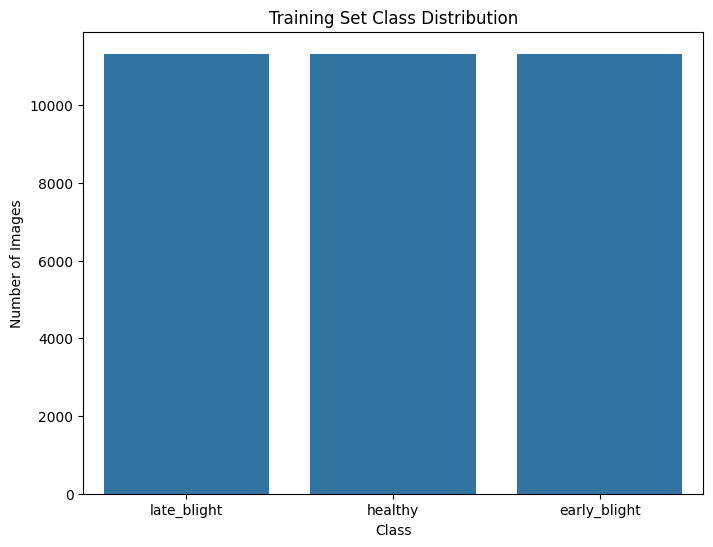

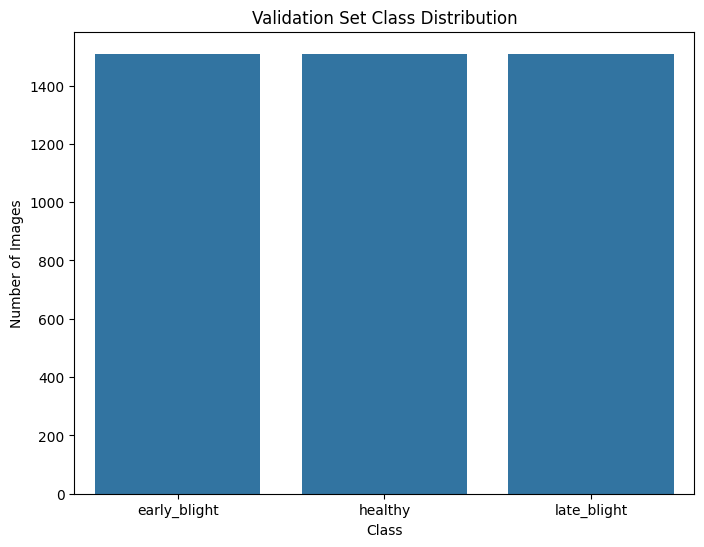

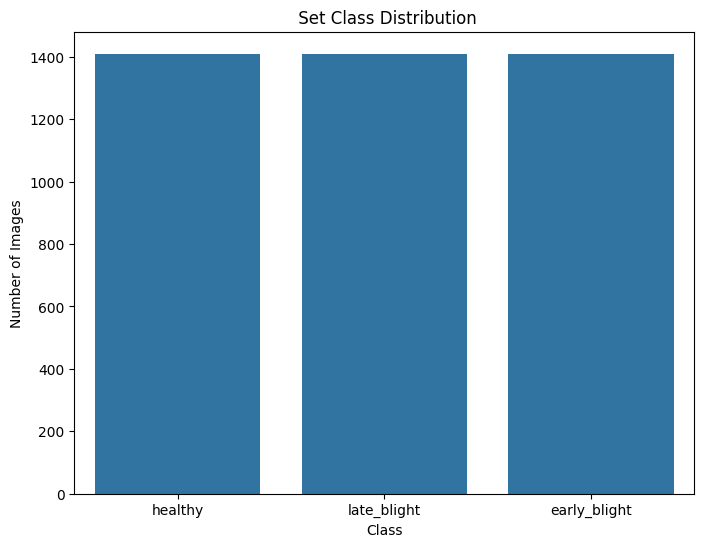

In [ ]:
plot_class_distribution(aug_train_class_counts, "Training Set Class Distribution")
plot_class_distribution(aug_val_class_counts, "Validation Set Class Distribution")
plot_class_distribution(aug_test_class_counts, " Set Class Distribution")

In [ ]:
compile_models(models)

Compiling CNN I model
Compiling CNN II model
Compiling MobileNetV2 model
Compiling ResNet50 model
Compiling DenseNet121 model


In [ ]:
model_results = train_models(
    models,
    aug_train_data,
    one_hot_encoded_aug_train_labels,
    aug_validation_data,
    one_hot_encoded_aug_validation_labels,
    epochs=5
)

============= Training using CNN I model =============
Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.9417 - loss: 0.1549 - val_accuracy: 0.2179 - val_loss: 43.0775
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.9483 - loss: 0.1534 - val_accuracy: 0.2274 - val_loss: 44.4526
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9344 - loss: 0.1743 - val_accuracy: 0.2313 - val_loss: 43.3550
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9718 - loss: 0.0842 - val_accuracy: 0.2124 - val_loss: 63.3155
============= Training using CNN II model =============
Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.9777 - loss: 0.0641 - val_accuracy: 0.2547 - val_loss: 31.7969
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9796 - loss: 0.0573 - val_accuracy: 0.2444 - val_loss: 31.2680
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9810 - loss: 0.0515 - val_accuracy: 0.2682 - va

133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0909 - loss: 54.5552
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0579 - loss: 48.5730
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.0854 - loss: 12.9582
133/133 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.3021 - loss: 4.1080
133/133 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.0553 - loss: 10.4479


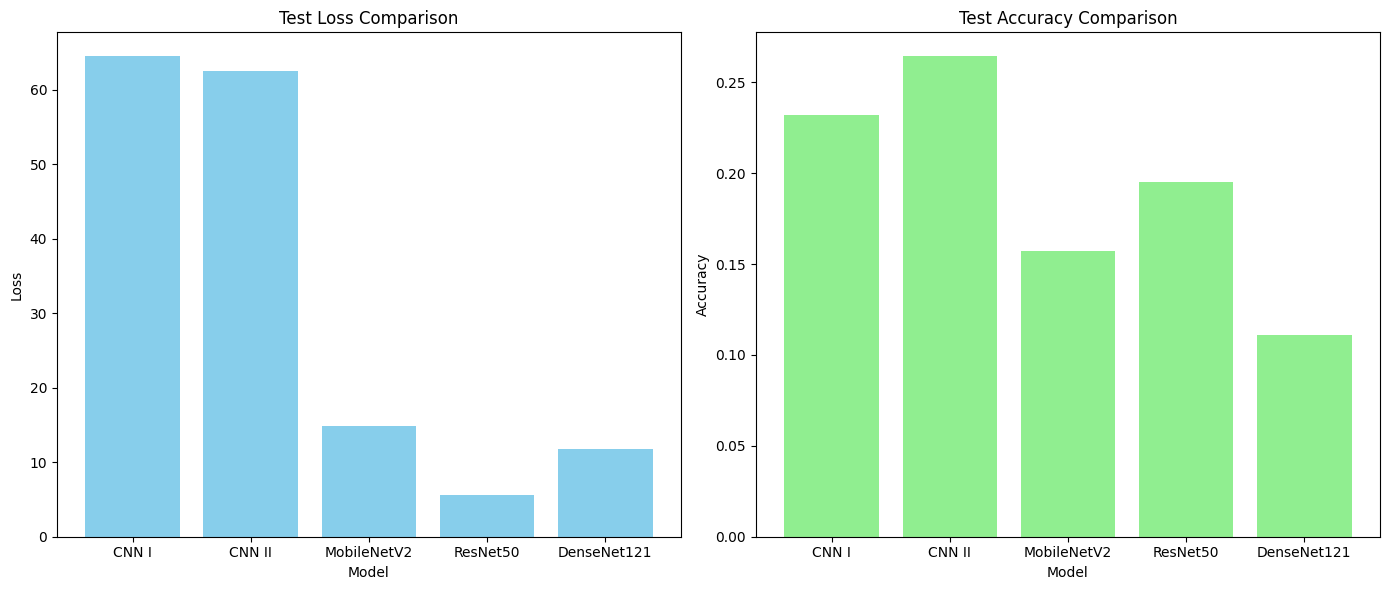

In [ ]:
compare_models_performance(models, aug_test_data, one_hot_encoded_aug_test_labels)

In [ ]:
generate_models_classification_report(models, aug_test_data, one_hot_encoded_aug_test_labels)

Classification Report for CNN I model:
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
              precision    recall  f1-score   support

           0       0.39      0.63      0.48      1410
           1       0.05      0.07      0.06      1410
           2       0.00      0.00      0.00      1410

    accuracy                           0.23      4230
   macro avg       0.15      0.23      0.18      4230
weighted avg       0.15      0.23      0.18      4230

Classification Report for CNN II model:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
              precision    recall  f1-score   support

           0       0.44      0.79      0.56      1410
           1       0.01      0.01      0.01      1410
           2       0.00      0.00      0.00      1410

    accuracy                           0.26      4230
   macro avg       0.15      0.26      0.19      4230
weighted avg       0.15      0.26      0.19      4230

Classification Report for MobileNetV2 model:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
              precision    recall  f1-score   support

           0       0.28      0.39      0.33      1410
           1       0.05      0.08      0.06      1410
           2       0.00      0.00      0.00      1410

    accuracy                           0.16      4230
   macro avg       0.11      0.16      0.13      4230
weighted avg       0.11      0.16      0.13      4230

Classification Report for ResNet50 model:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
              precision    recall  f1-score   support

           0       0.20      0.17      0.18      1410
           1       0.19      0.42      0.26      1410
           2       0.00      0.00      0.00      1410

    accuracy                           0.20      4230
   macro avg       0.13      0.20      0.15      4230
weighted avg       0.13      0.20      0.15      4230

Classification Report for DenseNet121 model:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
